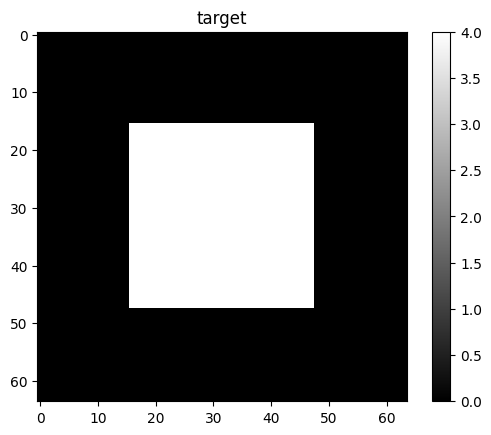

[[ 0  1  2 ... 61 62 63]
 [ 0  1  2 ... 61 62 63]
 [ 0  1  2 ... 61 62 63]
 ...
 [ 0  1  2 ... 61 62 63]
 [ 0  1  2 ... 61 62 63]
 [ 0  1  2 ... 61 62 63]]


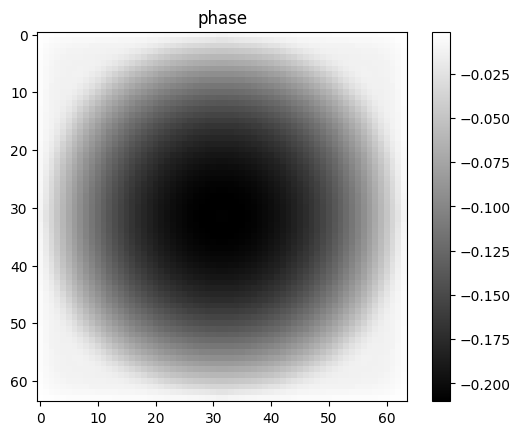

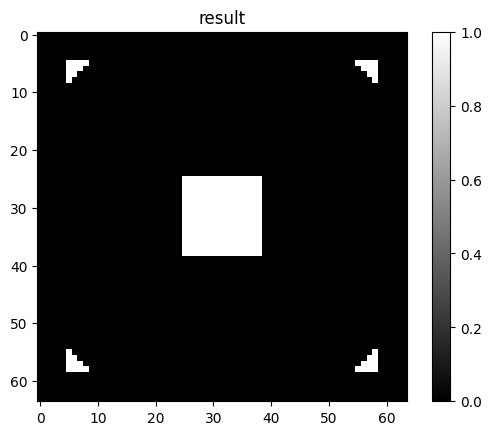

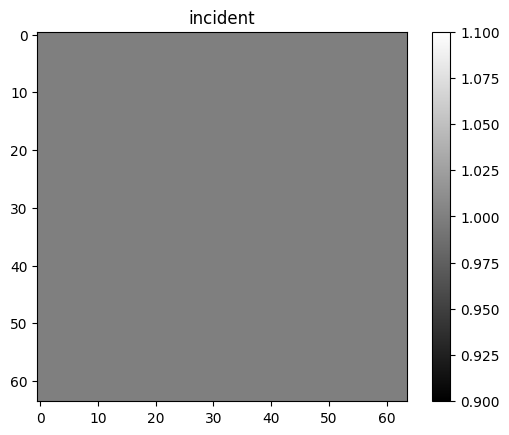

3860.0


In [38]:
#the third optimal method
import cv2 as op    #图像处理
import numpy as np #数组矩阵处理
from scipy import ndimage #求各方向梯度
from scipy.sparse.linalg import bicgstab    #共轭梯度法
import matplotlib.pyplot as plt #灰度图显示

#预先准备函数部分
#二维laplacian算子
def discrete_laplacian_2d_matrix(m, n):
    """
    生成一个m x n的二维离散拉普拉斯算子的系统矩阵。
    参数:
    m, n -- 矩阵的行和列的大小
    返回:
    L -- 二维离散拉普拉斯算子的系统矩阵
    """
    # 初始化矩阵
    L = np.zeros((m * n, m * n))
    
    # 遍历每个像素点
    for i in range(m):
        for j in range(n):
            idx = i * n + j  # 当前像素的索引
            # 计算拉普拉斯算子
            if i > 0:  # 上
                L[idx, idx - n] = 1
            if i < m - 1:  # 下
                L[idx, idx + n] = 1
            if j > 0:  # 左
                L[idx, idx - 1] = 1
            if j < n - 1:  # 右
                L[idx, idx + 1] = 1
            # 主对角线元素
            L[idx, idx] = -4
    
    return L

#定义目标图像和入射光束平面光强,每个单元格边长为160um,比例为6250:1,焦距应为20cm，同时按照比例来定义程序下焦距
row=64  #行
col=64  #列
target=np.zeros((row,col))
target[16:48,16:48]=4#目标光强
f=1250#按照比例折算而来，为离散化坐标系下定义焦距
incident=np.ones((row,col))#入射平面光束照度分布

#incident[1:30,1:30]=-3 验证负数是否可以用plt表示出来
#画图核实入射光束以及目标光强
plt.imshow(target, cmap='gray')
plt.colorbar()
plt.title('target')
plt.show()

#光源平面索引下标
I=np.tile(np.arange(row).reshape(row,1),(1,col))
J=np.tile(np.arange(col),(row,1))
print(J)
#光源平面实际物理坐标(1:160um)
X=I*0.00016
Y=J*0.00016

#laplacian矩阵
L_2D=discrete_laplacian_2d_matrix(row,col)

#迭代进行优化
for count in range(1,3):
    target_delete=-target+np.ones((row,col))
    #把原来图像化成列向量
    target_col=target_delete.reshape(-1,1)
    
    #使用双共轭梯度稳定迭代法求解 Ax = b
    p,exitcode=bicgstab(L_2D,target_col,atol=1)
    
    #求出p(x)，需要除去焦距,并且由列向量转为矩阵
    p=p/f
    p=p.reshape(row,col)
    
    # 计算矩阵 p 的 Sobel 梯度，并乘以实际的焦距长度（0.2m）
    dp_dx = f*ndimage.sobel(p, axis=0)  # x 方向上的梯度
    dp_dy = f*ndimage.sobel(p, axis=1)  # y 方向上的梯度
    
     # 映射后的目标平面实际物理坐标
    X_T = (I + dp_dx).astype(np.float32)
    Y_T = (J + dp_dy).astype(np.float32)
    
    #转为目标平面索引坐标
    I_T=X_T
    J_T=Y_T
    
    # 双线性插值,扭曲原来的图像
    target = op.remap(target.astype(np.float32), I_T, J_T, interpolation=op.INTER_LINEAR)

im_map=op.remap(incident.astype(np.float32),I_T, J_T, interpolation=op.INTER_LINEAR)
#最后一次图像扭曲的结果
plt.imshow(p, cmap='gray')
plt.colorbar()
plt.title('phase')
plt.show()
#映射结果
plt.imshow(im_map, cmap='gray')
plt.colorbar()
plt.title('result')
plt.show()
#入射
plt.imshow(incident, cmap='gray')
plt.colorbar()
plt.title('incident')
plt.show()

print(np.sum(incident)-np.sum(im_map))


In [31]:
import cv2 as op    #图像处理
import numpy as np #数组矩阵处理
from scipy import ndimage #求各方向梯度
from scipy.sparse.linalg import bicgstab    #共轭梯度法
import matplotlib.pyplot as plt #灰度图显示


p=np.ones((32,32))
dp_dx = ndimage.sobel(p, axis=0)  # x 方向上的梯度
dp_dy = ndimage.sobel(p, axis=1)  # y 方向上的梯度

print(dp_dx)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
